# Connect to drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Install necessary packages

In [ ]:
!pip install tensorflow scikit-learn matplotlib

# Importing Libraries

In [ ]:

from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_dir = '/content/gdrive/MyDrive/ISIC_Labelled -4GB'

# Load Images For Training & Testing

In [ ]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1 / 255,
                                validation_split=0.2,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory= data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.2,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 6837 images belonging to 8 classes.
Found 1704 images belonging to 8 classes.


# Initialize Densenet-121 Pretrained Model

In [ ]:
# Initializing DenseNet121 (pretrained) model with input image shape as (300, 300, 3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3), classes=8)

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False


# Add Custom Layer

In [ ]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(8, activation='softmax') # 8 Output Neurons for 8 Classes
])

In [ ]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# View Model Summary & Plot


In [ ]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 8095304 (30.88 MB)
Trainable params: 1057800 (4.04 MB)
Non-trainable params: 7037504 (26.85 MB)
____________

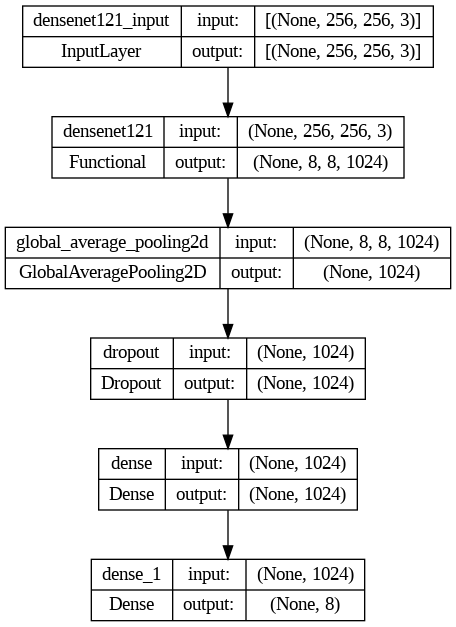

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# Model Building


In [ ]:
# Setting variables for the model
batch_size = 16
epochs = 30

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [ ]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 427
validation_steps : 106


# Model Training


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    verbose=1
)

Epoch 1/30
213/213 [==============================] - 2516s 12s/step - loss: 1.5489 - accuracy: 0.4354 - val_loss: 1.3640 - val_accuracy: 0.5071
Epoch 2/30
213/213 [==============================] - 2325s 11s/step - loss: 1.3709 - accuracy: 0.4999 - val_loss: 1.2742 - val_accuracy: 0.5472
Epoch 3/30
213/213 [==============================] - 2393s 11s/step - loss: 1.3192 - accuracy: 0.5109 - val_loss: 1.2475 - val_accuracy: 0.5377
Epoch 4/30
213/213 [==============================] - 2339s 11s/step - loss: 1.2862 - accuracy: 0.5278 - val_loss: 1.2249 - val_accuracy: 0.5448
Epoch 5/30
213/213 [==============================] - 2337s 11s/step - loss: 1.2553 - accuracy: 0.5412 - val_loss: 1.1993 - val_accuracy: 0.5672
Epoch 6/30
213/213 [==============================] - 2339s 11s/step - loss: 1.2458 - accuracy: 0.5362 - val_loss: 1.1994 - val_accuracy: 0.5643
Epoch 7/30
213/213 [==============================] - 2394s 11s/step - loss: 1.2219 - accuracy: 0.5530 - val_loss: 1.1940 - val_ac

#  Model Evaluation


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)